In [1]:
import torch
import copy
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Add the parent directory to the Python path - bad practice, but it's just for the example
import sys
sys.path.append("/home/heydari/FHHI-XAI/")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.datasets.DLR_dataset import DatasetDLR
from src.plot_crp_explanations import plot_explanations, plot_one_image_explanation
from src.minio_client import MinIOClient
from LCRP.models import get_model 
from LCRP.utils.crp_configs import ATTRIBUTORS, CANONIZERS, VISUALIZATIONS, COMPOSITES

import logging
# Suppress specific noisy libraries if needed
logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("numba").setLevel(logging.WARNING)



/home/heydari/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- imports
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import tqdm
from src.datasets.flood_dataset import FloodDataset

# --- data / transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

root_dir = "../data/flood_segmentation/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)
print('Loaded dataset:', type(dataset))
print('len(dataset) =', len(dataset))

# --- device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# --- model / checkpoint
model_name = "pidnet"
ckpt_path = "../models/flood_model.pt"

# ========= HACK: prevent get_model()/get_pidnet() from trying to strictly load its OWN checkpoint =========
# Some internal path calls `model.load_state_dict(torch.load(cfg["ckpt_path"]))` with strict=True,
# which raises due to "model." prefix or different head. We temporarily force:
#   - torch.load -> always map to CPU (safe on CPU-only)
#   - nn.Module.load_state_dict -> always use strict=False
_orig_torch_load = torch.load
_orig_load_state_dict = torch.nn.Module.load_state_dict

def _cpu_load(*args, **kwargs):
    kwargs.setdefault("map_location", "cpu")
    return _orig_torch_load(*args, **kwargs)

def _lenient_load_state_dict(self, state_dict, strict=True):
    # Force non-strict to avoid internal RuntimeError during model construction
    return _orig_load_state_dict(self, state_dict, strict=False)

torch.load = _cpu_load
torch.nn.Module.load_state_dict = _lenient_load_state_dict
try:
    # Build the model; any internal checkpoint load will be lenient and won't crash
    model = get_model(model_name=model_name, device=device, classes=2)
finally:
    # Restore patched functions
    torch.load = _orig_torch_load
    torch.nn.Module.load_state_dict = _orig_load_state_dict

# ========= Now load YOUR checkpoint properly (handle "model." / "module." prefixes) =========
def _extract_state_dict(obj):
    if isinstance(obj, dict):
        for k in ("state_dict", "model_state", "model", "net", "module"):
            if k in obj and isinstance(obj[k], dict):
                return obj[k]
    return obj

def _strip_prefix(sd, prefix):
    if any(k.startswith(prefix) for k in sd.keys()):
        return {k[len(prefix):]: v for k, v in sd.items()}
    return sd

raw_sd = torch.load(ckpt_path, map_location="cpu")
sd = _extract_state_dict(raw_sd)
sd = _strip_prefix(sd, "model.")
sd = _strip_prefix(sd, "module.")

missing, unexpected = model.load_state_dict(sd, strict=False)
if missing:
    print("[load_state_dict] Missing keys:", len(missing))
    # print(missing)  # uncomment for full list
if unexpected:
    print("[load_state_dict] Unexpected keys:", len(unexpected))
    # print(unexpected)  # uncomment for full list

# finalize
model.to(device)
model.eval()
model.augment = False

output_dir = "../examples/output/crp/pidnet_flood_BRK"
print(f"Model ready on {device}. Output dir: {output_dir}")


Loaded dataset: <class 'src.datasets.flood_dataset.FloodDataset'>
len(dataset) = 1321
Loaded checkpoint ../models/flood_model.pt
Model ready on cuda:0. Output dir: ../examples/output/crp/pidnet_flood_BRK


In [3]:
# --- validation evaluation: Mean IoU, Pixel Acc, Mean Acc, per-class IoU
import numpy as np
import torch
import torch.nn.functional as F
from types import SimpleNamespace
from pathlib import Path as PathlibPath
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.datasets.flood_dataset import FloodDataset
from src.utils.utils import get_confusion_matrix

# minimal config matching the previous general_flood_v3 settings
cfg = SimpleNamespace(
    DATASET=SimpleNamespace(
        NUM_CLASSES=2,
    ),
    MODEL=SimpleNamespace(
        NUM_OUTPUTS=1,
        ALIGN_CORNERS=True,
    ),
    TEST=SimpleNamespace(
        OUTPUT_INDEX=-1,
        BASE_SIZE=2048,
        IMAGE_SIZE=[1280, 720],
    ),
    TRAIN=SimpleNamespace(
        IGNORE_LABEL=-1,
        SCALE_FACTOR=16,
    ),
)

val_root = PathlibPath("../data/flood_segmentation/").resolve()
val_dataset = FloodDataset(
    root_dir=str(val_root),
    split="val",
    transform=transform,
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# quick sanity check on paired counts
print("Validation samples (paired):", len(val_dataset))

def evaluate_val(model, loader, cfg, device=device):
    model.eval()
    confusion = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES))
    with torch.no_grad():
        for image, label, _, _, _, _ in tqdm(loader, total=len(loader), desc="val"):
            image = image.to(device)
            label = label.to(device)

            pred = val_dataset.single_scale_inference(cfg, model, image)
            if pred.shape[-2:] != label.shape[-2:]:
                pred = F.interpolate(
                    pred, label.shape[-2:], mode="bilinear", align_corners=cfg.MODEL.ALIGN_CORNERS
                )

            confusion += get_confusion_matrix(
                label, pred, label.size(), cfg.DATASET.NUM_CLASSES, cfg.TRAIN.IGNORE_LABEL
            )

    pos = confusion.sum(1)
    res = confusion.sum(0)
    tp = np.diag(confusion)
    pixel_acc = tp.sum() / pos.sum()
    mean_acc = (tp / np.maximum(1.0, pos)).mean()
    class_iou = tp / np.maximum(1.0, pos + res - tp)
    mean_iou = class_iou.mean()

    print(f"Pixel_Acc: {pixel_acc:.4f}")
    print(f"Mean_Acc: {mean_acc:.4f}")
    print(f"Mean_IoU: {mean_iou:.4f}")
    for idx, iou in enumerate(class_iou):
        print(f"Class {idx} IoU: {iou:.4f}")

    return mean_iou, class_iou, pixel_acc, mean_acc



Validation samples (paired): 244


In [4]:
# --- validation evaluation: Mean IoU, Pixel Acc, Mean Acc, per-class IoU
import numpy as np
import torch
import torch.nn.functional as F
from types import SimpleNamespace
from pathlib import Path as PathlibPath
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.datasets.flood_dataset_metrics import FloodDataset
from src.utils.utils import get_confusion_matrix

# minimal config (only things we actually need here)
cfg = SimpleNamespace(
    DATASET=SimpleNamespace(
        NUM_CLASSES=2,
    ),
    MODEL=SimpleNamespace(
        NUM_OUTPUTS=1,
        ALIGN_CORNERS=True,
    ),
    TEST=SimpleNamespace(
        OUTPUT_INDEX=-1,
        BASE_SIZE=2048,
        IMAGE_SIZE=[1280, 720],
    ),
    TRAIN=SimpleNamespace(
        IGNORE_LABEL=-1,   # just a default; real value comes from dataset
        SCALE_FACTOR=16,
    ),
)

# root should point to folder that either contains "General_Flood_v3"
# or is itself the General_Flood_v3 folder
val_root = PathlibPath("../data").resolve()

val_dataset = FloodDataset(
    root_dir=str(val_root),
    split="val",
    transform=transform,
    multi_scale=False,
    flip=False,
    # NOTE: we do NOT pass ignore_label here -> use FloodDataset's default
    base_size=cfg.TEST.BASE_SIZE,
    crop_size=(cfg.TEST.IMAGE_SIZE[1], cfg.TEST.IMAGE_SIZE[0]),
    scale_factor=cfg.TRAIN.SCALE_FACTOR,
    return_or_dims=True,
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# quick sanity check on paired counts + ignore label
print("Validation samples (paired):", len(val_dataset))
print("Dataset ignore_label:", getattr(val_dataset, "ignore_label", None))

def evaluate_val(model, loader, cfg, device):
    model.eval()
    confusion = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES))
    # take ignore_label from the dataset, fall back to cfg if missing
    ignore_label = getattr(loader.dataset, "ignore_label", cfg.TRAIN.IGNORE_LABEL)

    with torch.no_grad():
        # optional: one-time debug flag to inspect ignore pixels
        debug_once = True

        for image, label, _, _, _, _ in tqdm(loader, total=len(loader), desc="val"):
            image = image.to(device)
            label = label.to(device)

            pred = loader.dataset.single_scale_inference(cfg, model, image)
            if pred.shape[-2:] != label.shape[-2:]:
                pred = F.interpolate(
                    pred,
                    label.shape[-2:],
                    mode="bilinear",
                    align_corners=cfg.MODEL.ALIGN_CORNERS,
                )

            # Optional debug: see how many pixels are actually ignored
            if debug_once:
                n_ignore = (label == ignore_label).sum().item()
                n_total = label.numel()
                print(f"Ignore pixels in first batch: {n_ignore}/{n_total}")
                debug_once = False

            confusion += get_confusion_matrix(
                label,
                pred,
                label.size(),
                cfg.DATASET.NUM_CLASSES,
                ignore_label,   # <-- using dataset's ignore_label
            )

    pos = confusion.sum(1)
    res = confusion.sum(0)
    tp = np.diag(confusion)

    pixel_acc = tp.sum() / pos.sum()
    mean_acc = (tp / np.maximum(1.0, pos)).mean()
    class_iou = tp / np.maximum(1.0, pos + res - tp)
    mean_iou = class_iou.mean()

    print(f"Pixel_Acc: {pixel_acc:.4f}")
    print(f"Mean_Acc:  {mean_acc:.4f}")
    print(f"Mean_IoU:  {mean_iou:.4f}")
    for idx, iou in enumerate(class_iou):
        print(f"Class {idx} IoU: {iou:.4f}")

    return mean_iou, class_iou, pixel_acc, mean_acc


Validation samples (paired): 244
Dataset ignore_label: -1


In [ ]:
mean_iou, class_iou, pixel_acc, mean_acc = evaluate_val(model, val_loader, cfg, device)
print("Returned:", mean_iou, class_iou, pixel_acc, mean_acc)


In [5]:
# --- imports
import torch
from torchvision import transforms
from src.datasets.flood_datase_crp import FloodDataset 
output_dir = "../examples/output/crp/pidnet_flood_BRK"
# --- data / transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

root_dir = "../data/flood_segmentation/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)
print('Loaded dataset:', type(dataset))
print('len(dataset) =', len(dataset))

run_analysis(model_name, model, dataset, output_dir=output_dir, device=device)

Loaded dataset: <class 'src.datasets.flood_datase_crp.FloodDataset'>
len(dataset) = 1321
Running Analysis...


  0%|          | 0/166 [00:00<?, ?it/s]ERROR:LCRP.utils.crp:Prediction time: 0.11365675926208496, Backward time: 0.27877044677734375, Full attribution time: 0.2788863182067871
ERROR:LCRP.utils.crp:Prediction time: 0.12293028831481934, Backward time: 0.14232277870178223, Full attribution time: 0.14239954948425293
  1%|          | 2/166 [00:03<04:35,  1.68s/it]ERROR:LCRP.utils.crp:Prediction time: 0.13210701942443848, Backward time: 0.1449575424194336, Full attribution time: 0.1450366973876953
ERROR:LCRP.utils.crp:Prediction time: 0.13301444053649902, Backward time: 0.14303994178771973, Full attribution time: 0.14312458038330078
  2%|▏         | 3/166 [00:06<06:30,  2.39s/it]ERROR:LCRP.utils.crp:Prediction time: 0.12879729270935059, Backward time: 0.14431142807006836, Full attribution time: 0.14438891410827637
ERROR:LCRP.utils.crp:Prediction time: 0.1266922950744629, Backward time: 0.14304161071777344, Full attribution time: 0.14312195777893066
  2%|▏         | 4/166 [00:10<07:32,  2.80s

100%|██████████| 150/150 [00:00<00:00, 2004.92it/s]


Loaded dataset: <class 'src.datasets.flood_datase_crp.FloodDataset'>
len(dataset) = 1321
torch.Size([3, 1280, 720])
MEMORY STARTING: 0.03GB (max: 0.03GB)
MEMORY AFTER FIGURE CREATION: 0.04GB (max: 0.04GB)
MEMORY BEFORE SEGMENTATION ATTR: 0.04GB (max: 0.04GB)


/home/heydari/.local/lib/python3.10/site-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
ERROR:LCRP.utils.crp:Prediction time: 0.14843058586120605, Backward time: 0.2256333827972412, Full attribution time: 0.23517656326293945


MEMORY AFTER SEGMENTATION ATTR: 0.04GB (max: 0.04GB)
MEMORY AFTER DETECTION/SEGMENTATION: 0.04GB (max: 0.04GB)
Concepts: torch.return_types.topk(
values=tensor([0.1002, 0.0047, 0.0021]),
indices=tensor([216, 116, 205]))
MEMORY BEFORE CONDITIONAL HEATMAPS: 0.04GB (max: 0.04GB)


ERROR:LCRP.utils.crp:Prediction time: 0.2440052032470703, Backward time: 0.651193380355835, Full attribution time: 0.673029899597168
DEBUG:src.plot_crp_explanations:Time to compute conditional heatmaps: 0.97s


MEMORY AFTER CONDITIONAL HEATMAPS: 0.04GB (max: 0.04GB)
Computing reference images...
MEMORY BEFORE REF IMAGES: 0.04GB (max: 0.04GB)


ERROR:LCRP.utils.crp:Prediction time: 0.18334460258483887, Backward time: 0.3684353828430176, Full attribution time: 0.3753805160522461
ERROR:LCRP.utils.crp:Prediction time: 0.13299202919006348, Backward time: 0.39908623695373535, Full attribution time: 0.40612220764160156
ERROR:LCRP.utils.crp:Prediction time: 0.1338822841644287, Backward time: 0.40354442596435547, Full attribution time: 0.41061973571777344
ERROR:LCRP.utils.crp:Prediction time: 0.1314833164215088, Backward time: 0.39835476875305176, Full attribution time: 0.405350923538208
ERROR:LCRP.utils.crp:Prediction time: 0.13357186317443848, Backward time: 0.40060997009277344, Full attribution time: 0.4077460765838623
ERROR:LCRP.utils.crp:Prediction time: 0.13443446159362793, Backward time: 0.406970739364624, Full attribution time: 0.41692686080932617
ERROR:LCRP.utils.crp:Prediction time: 0.16192150115966797, Backward time: 0.33916568756103516, Full attribution time: 0.3462483882904053
ERROR:LCRP.utils.crp:Prediction time: 0.1320

MEMORY AFTER REF IMAGES: 0.04GB (max: 0.04GB)
Plotting...
MEMORY PLOTTING CONCEPT 0: 0.04GB (max: 0.04GB)
MEMORY PLOTTING CONCEPT 1: 0.04GB (max: 0.04GB)
MEMORY PLOTTING CONCEPT 2: 0.04GB (max: 0.04GB)
MEMORY PLOTTING CONCEPT 3: 0.04GB (max: 0.04GB)


DEBUG:src.plot_crp_explanations:Time to plot: 0.68s


MEMORY AFTER PLOTTING: 0.04GB (max: 0.04GB)


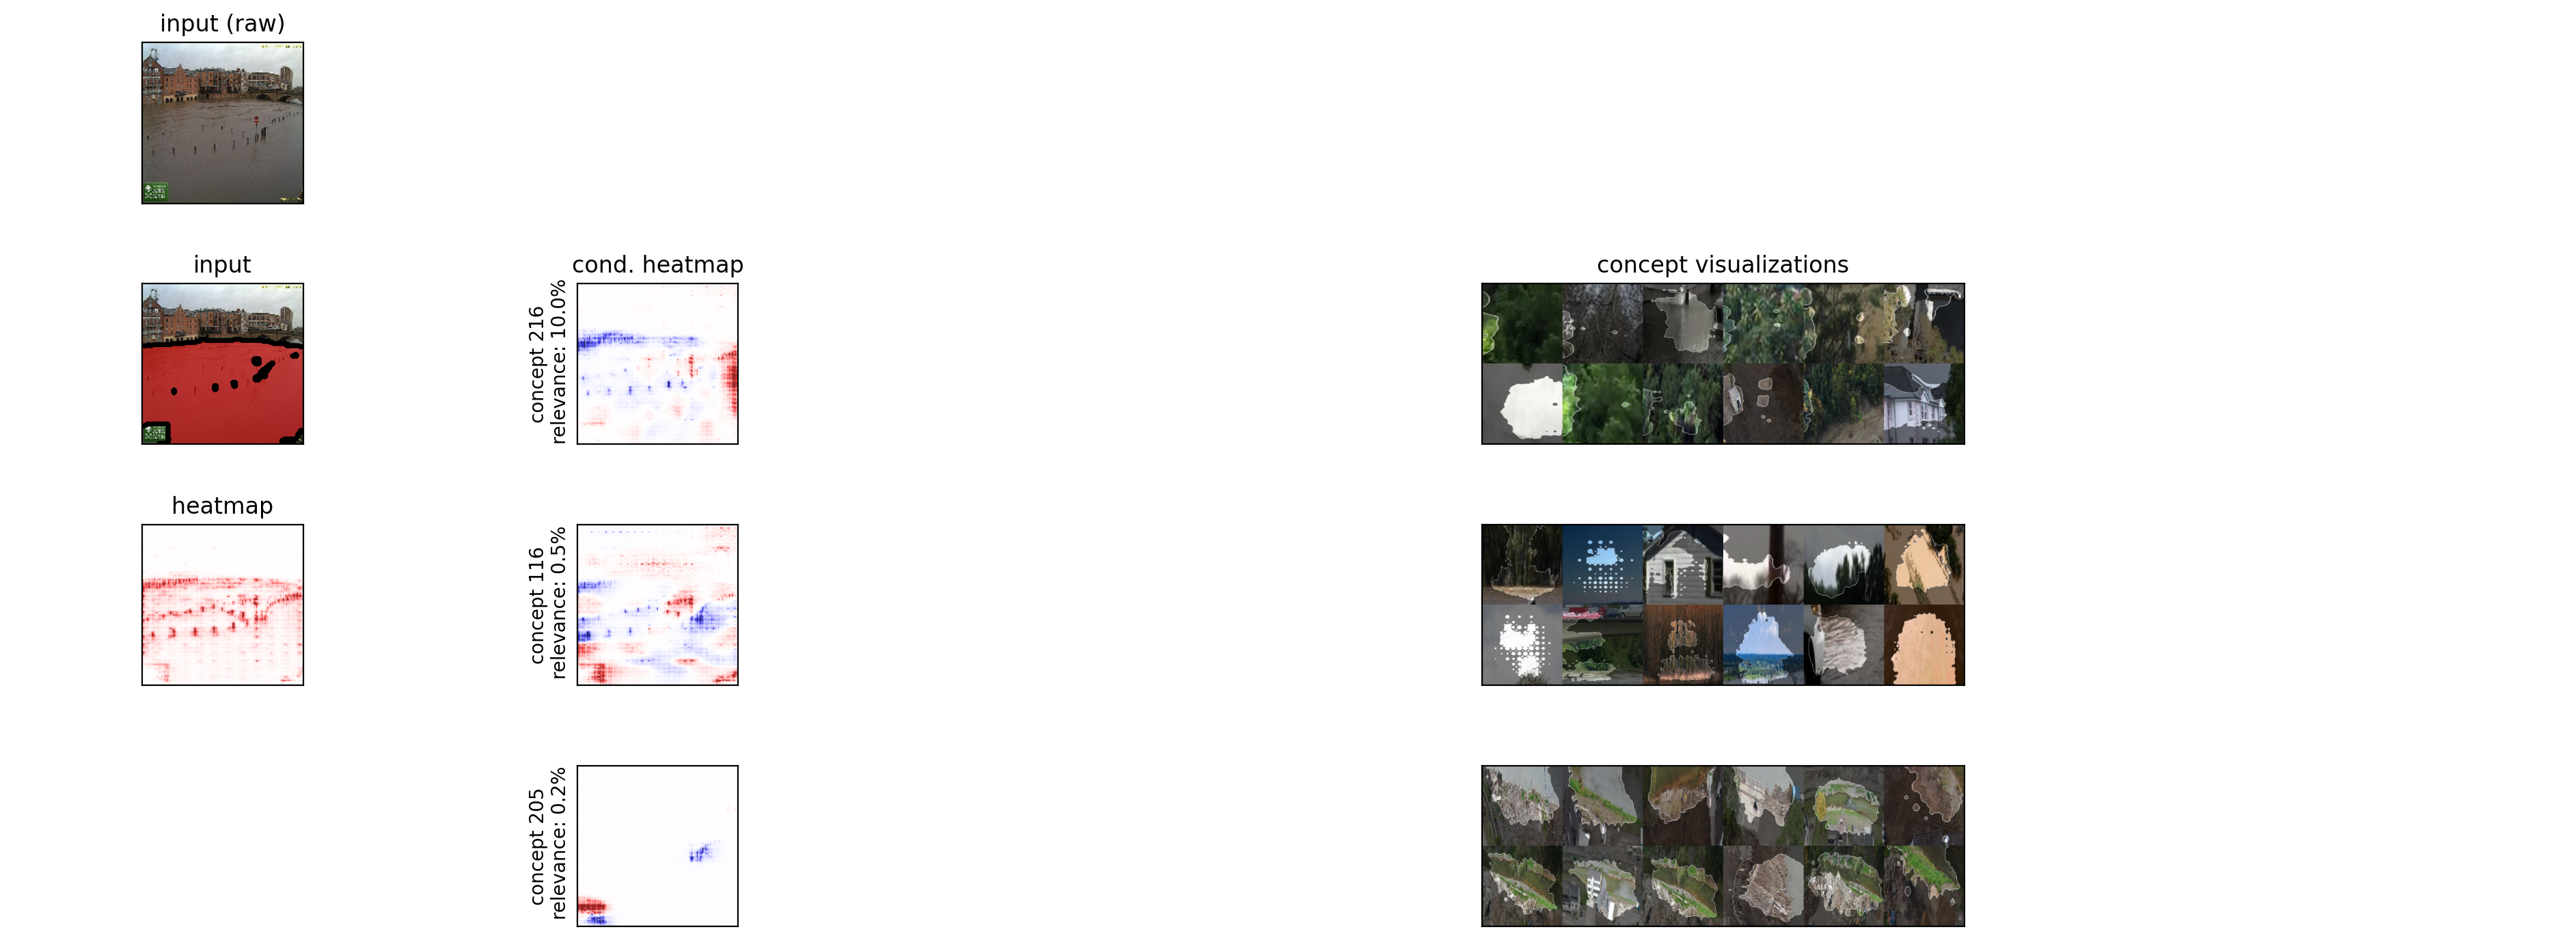

Done plotting.


In [6]:
# Setting up main parameters
class_id = 1
sample_id = 0
n_concepts = 3
n_refimgs = 12
layer = "layer4.2.conv1"
# layer = "layer1.1.conv1"
mode = "relevance"
prediction_num = 0

root_dir = "../data/flood_segmentation/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)
print('Loaded dataset:', type(dataset))
print('len(dataset) =', len(dataset))


# if failing, try to restart the notebook and do not run analysis again, go directly to plotting
plot_explanations(model_name, model, dataset, sample_id, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)

In [7]:
import os
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from datetime import datetime
from tqdm import tqdm
from torchvision.utils import make_grid

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept


In [15]:
from collections import defaultdict

dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
cc = ChannelConcept()
output_dir_crp = "../examples/output/crp/pidnet_flood_BRK/"

layer_names = get_layer_names(model, [torch.nn.Conv2d])
attribution = ATTRIBUTORS[model_name](model)
composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
condition = [{"y": class_id}]
fv = VISUALIZATIONS[model_name](
    attribution, dataset, layer_names,
    preprocess_fn=lambda x: x, path=output_dir_crp, max_target="max"
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

#start = datetime.now()
activations = defaultdict(list)
attributions = defaultdict(list)

for i, (x, y) in enumerate(tqdm(dataset)):
    x = x.to(device).requires_grad_()
    attr = attribution(x.unsqueeze(0), condition, composite, record_layer=layer_names)

    for ln in layer_names:
        if ln not in attr.activations or ln not in attr.relevances:
            continue

        acts = attr.activations[ln].amax((-2, -1)).detach().cpu()
        rels = cc.attribute(attr.relevances[ln], abs_norm=True).detach().cpu()
        acts = torch.nan_to_num(acts, nan=0.0, posinf=0.0, neginf=0.0)
        rels = torch.nan_to_num(rels, nan=0.0, posinf=0.0, neginf=0.0)

        activations[ln].append(acts)
        attributions[ln].append(rels)

for ln, act_list in activations.items():
    if not attributions[ln]:
        continue

    act_tensor = torch.nan_to_num(torch.cat(act_list), nan=0.0, posinf=0.0, neginf=0.0)
    rel_tensor = torch.nan_to_num(torch.cat(attributions[ln]), nan=0.0, posinf=0.0, neginf=0.0)

    folder = os.path.join("/home/heydari/FHHI-XAI/examples/output/pcx/pidnet_flood_BRK/", ln)
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, "activations.npy"), act_tensor.numpy())
    np.save(os.path.join(folder, "attributions.npy"), rel_tensor.numpy())

#end = datetime.now()
#print(f"elapsed: {end - start}")


100%|██████████| 1321/1321 [19:04<00:00,  1.15it/s]


Loaded dataset: <class 'src.datasets.flood_datase_crp.FloodDataset'>
len(dataset) = 1321
[plot_pcx_explanations] starting
[plot_pcx_explanations] sample_id=0 img.shape=(3, 1280, 720)
[plot_one_image_pcx_explanation] device=cpu, layer=layer3.0.conv1
[attr] building attribution/composite/visualization
[attr] layer_map size=79
[data] x.shape=(1, 3, 1280, 720)
[attr] computing base attribution
[attr] base heatmap computed
[mask] building predicted mask
[mask] reverse_augmentation available, target size=(1280, 720)
[mask] resized mask -> (1280, 720)
[concepts] computing channel relevances
[concepts] channel_rels shape=(1, 128)
[concepts] topk_ind=[123, 63, 116, 39, 60] topk_rel=[0.16300000250339508, 0.11900000274181366, 0.09099999815225601, 0.07999999821186066, 0.0430000014603138]
[attr] computing conditional heatmaps
[refs] computing/loading reference images
[get_ref_images] start; layer=layer3.0.conv1, n_ref=12, cache=../examples/ref_images_pidnet_flood_BRK/layer3.0.conv1.h5
[get_ref_imag

/home/heydari/.local/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
/home/heydari/.local/lib/python3.10/site-packages/zennit/image.py:188: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).clip(0, 255).astype(np.uint8)


[proto] building prototype mask
[plot] assembling figure
[plot_pcx_explanations] finished


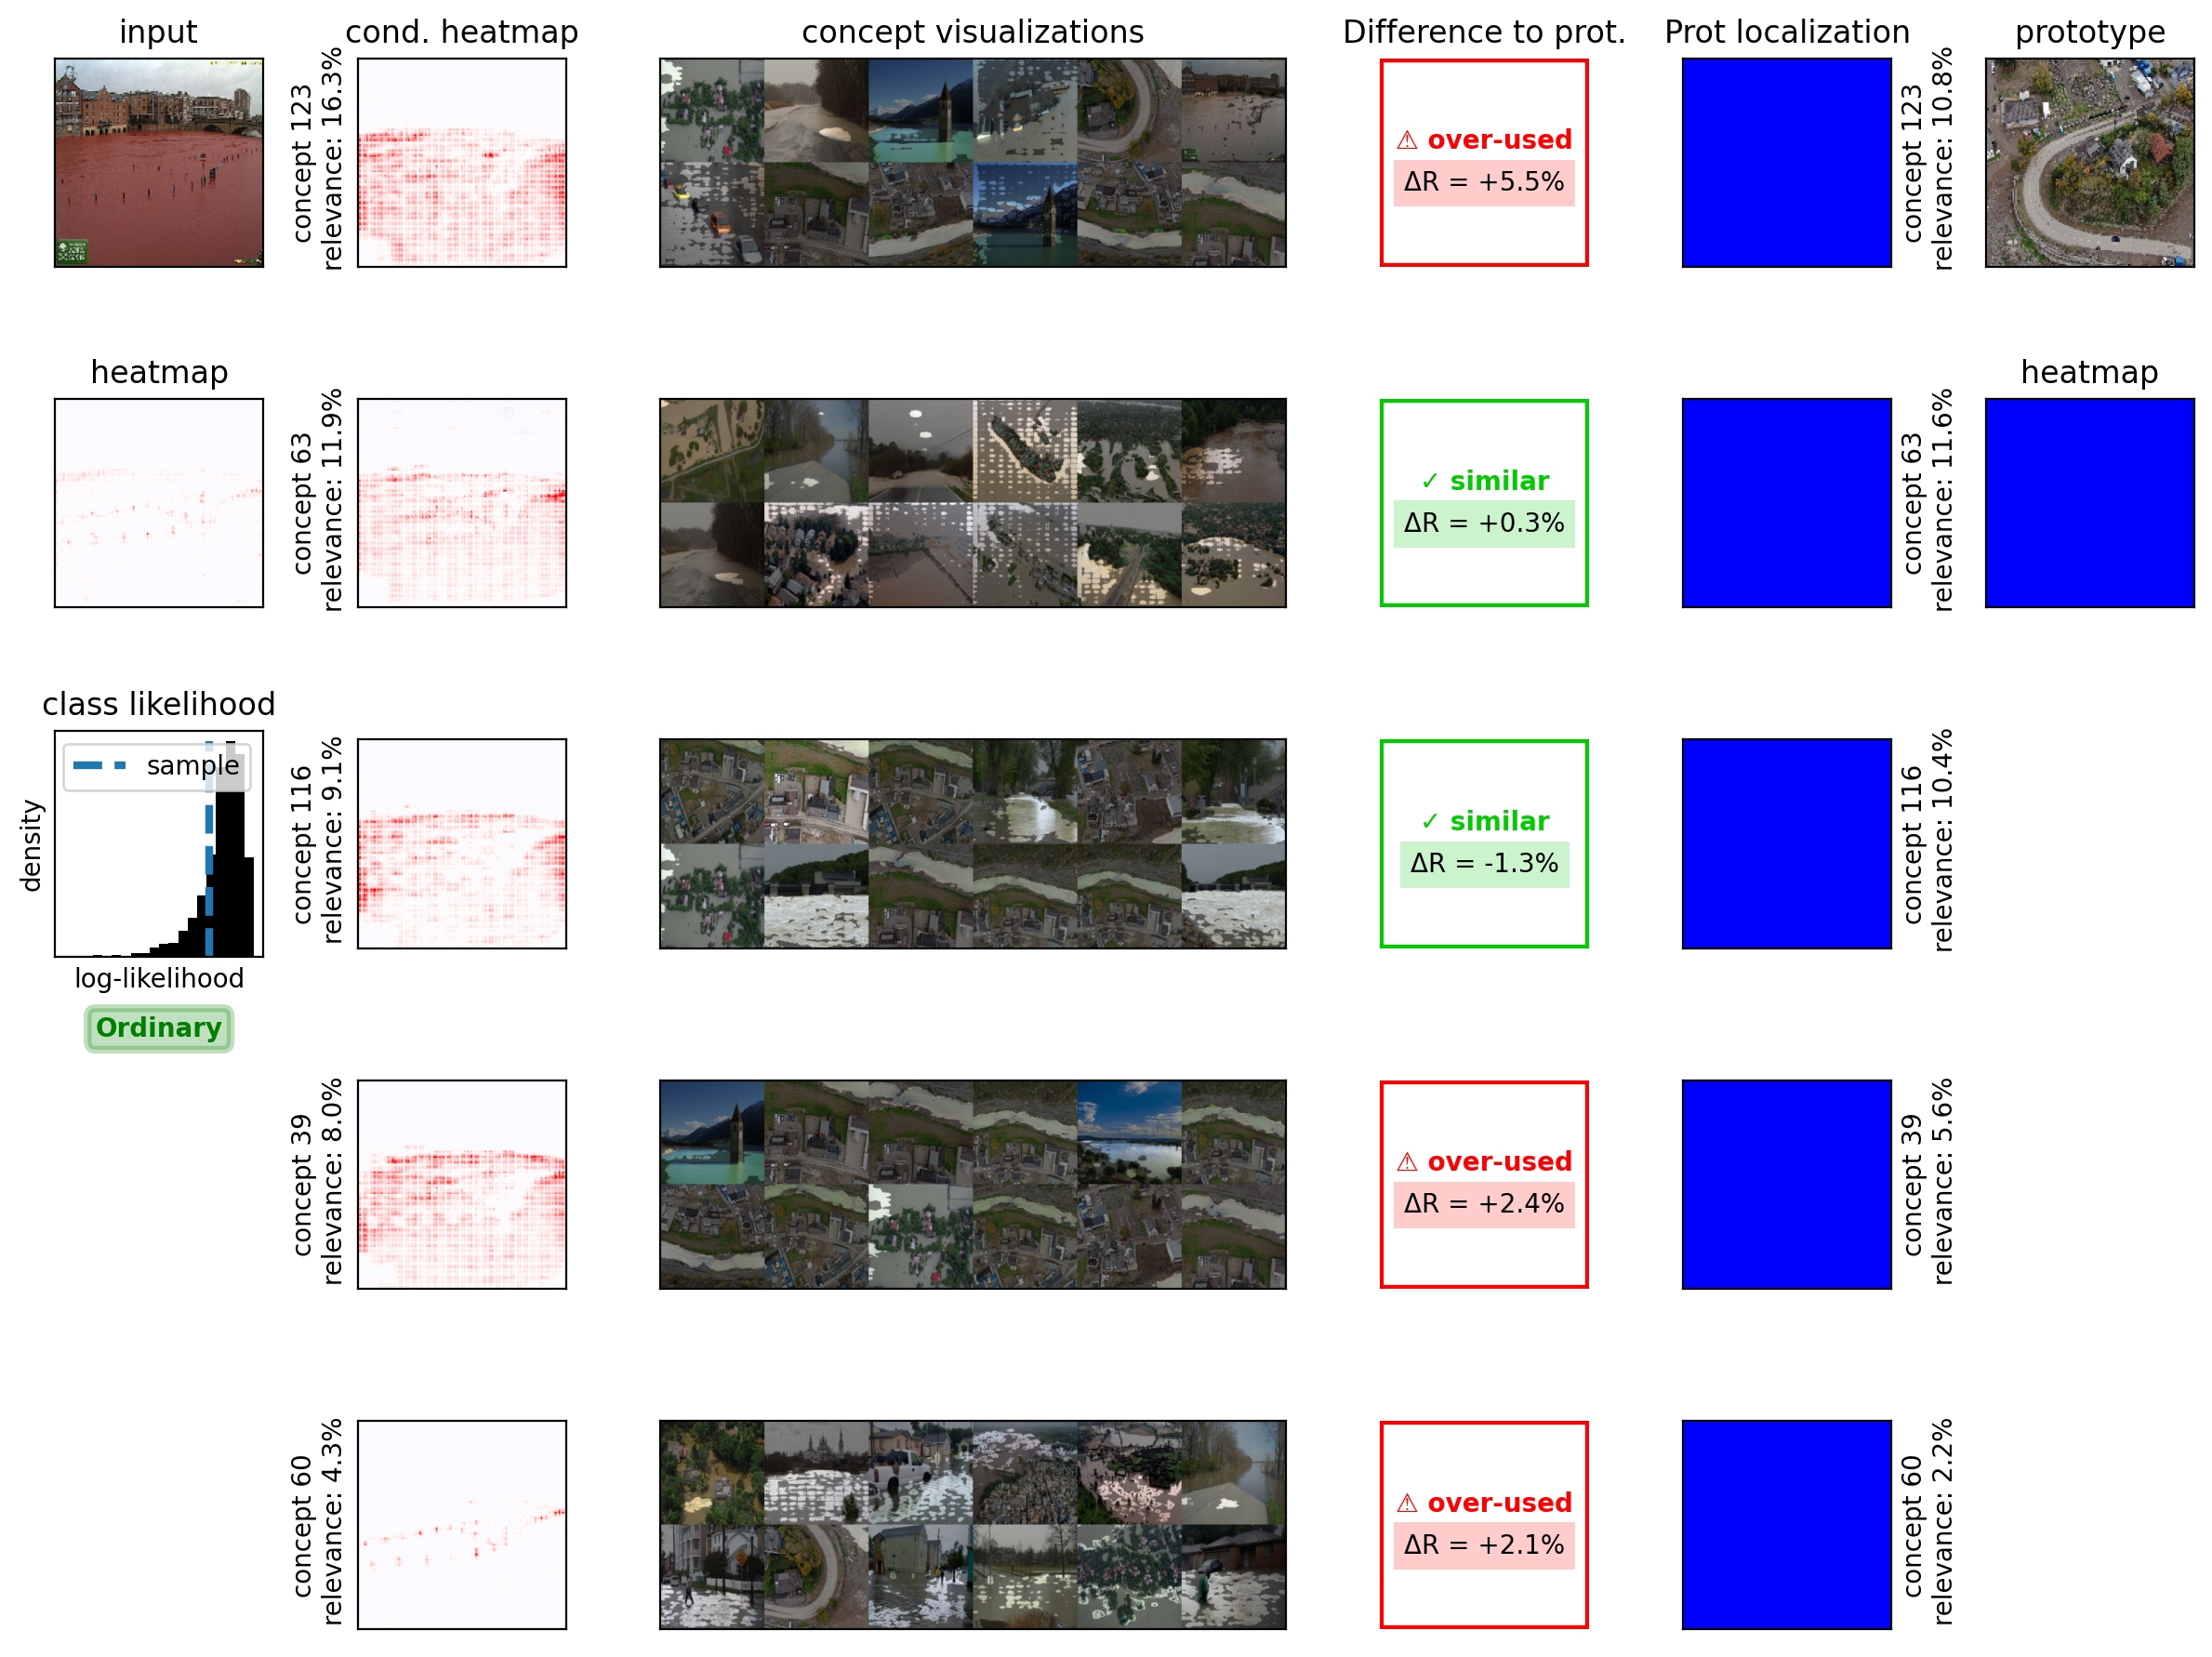

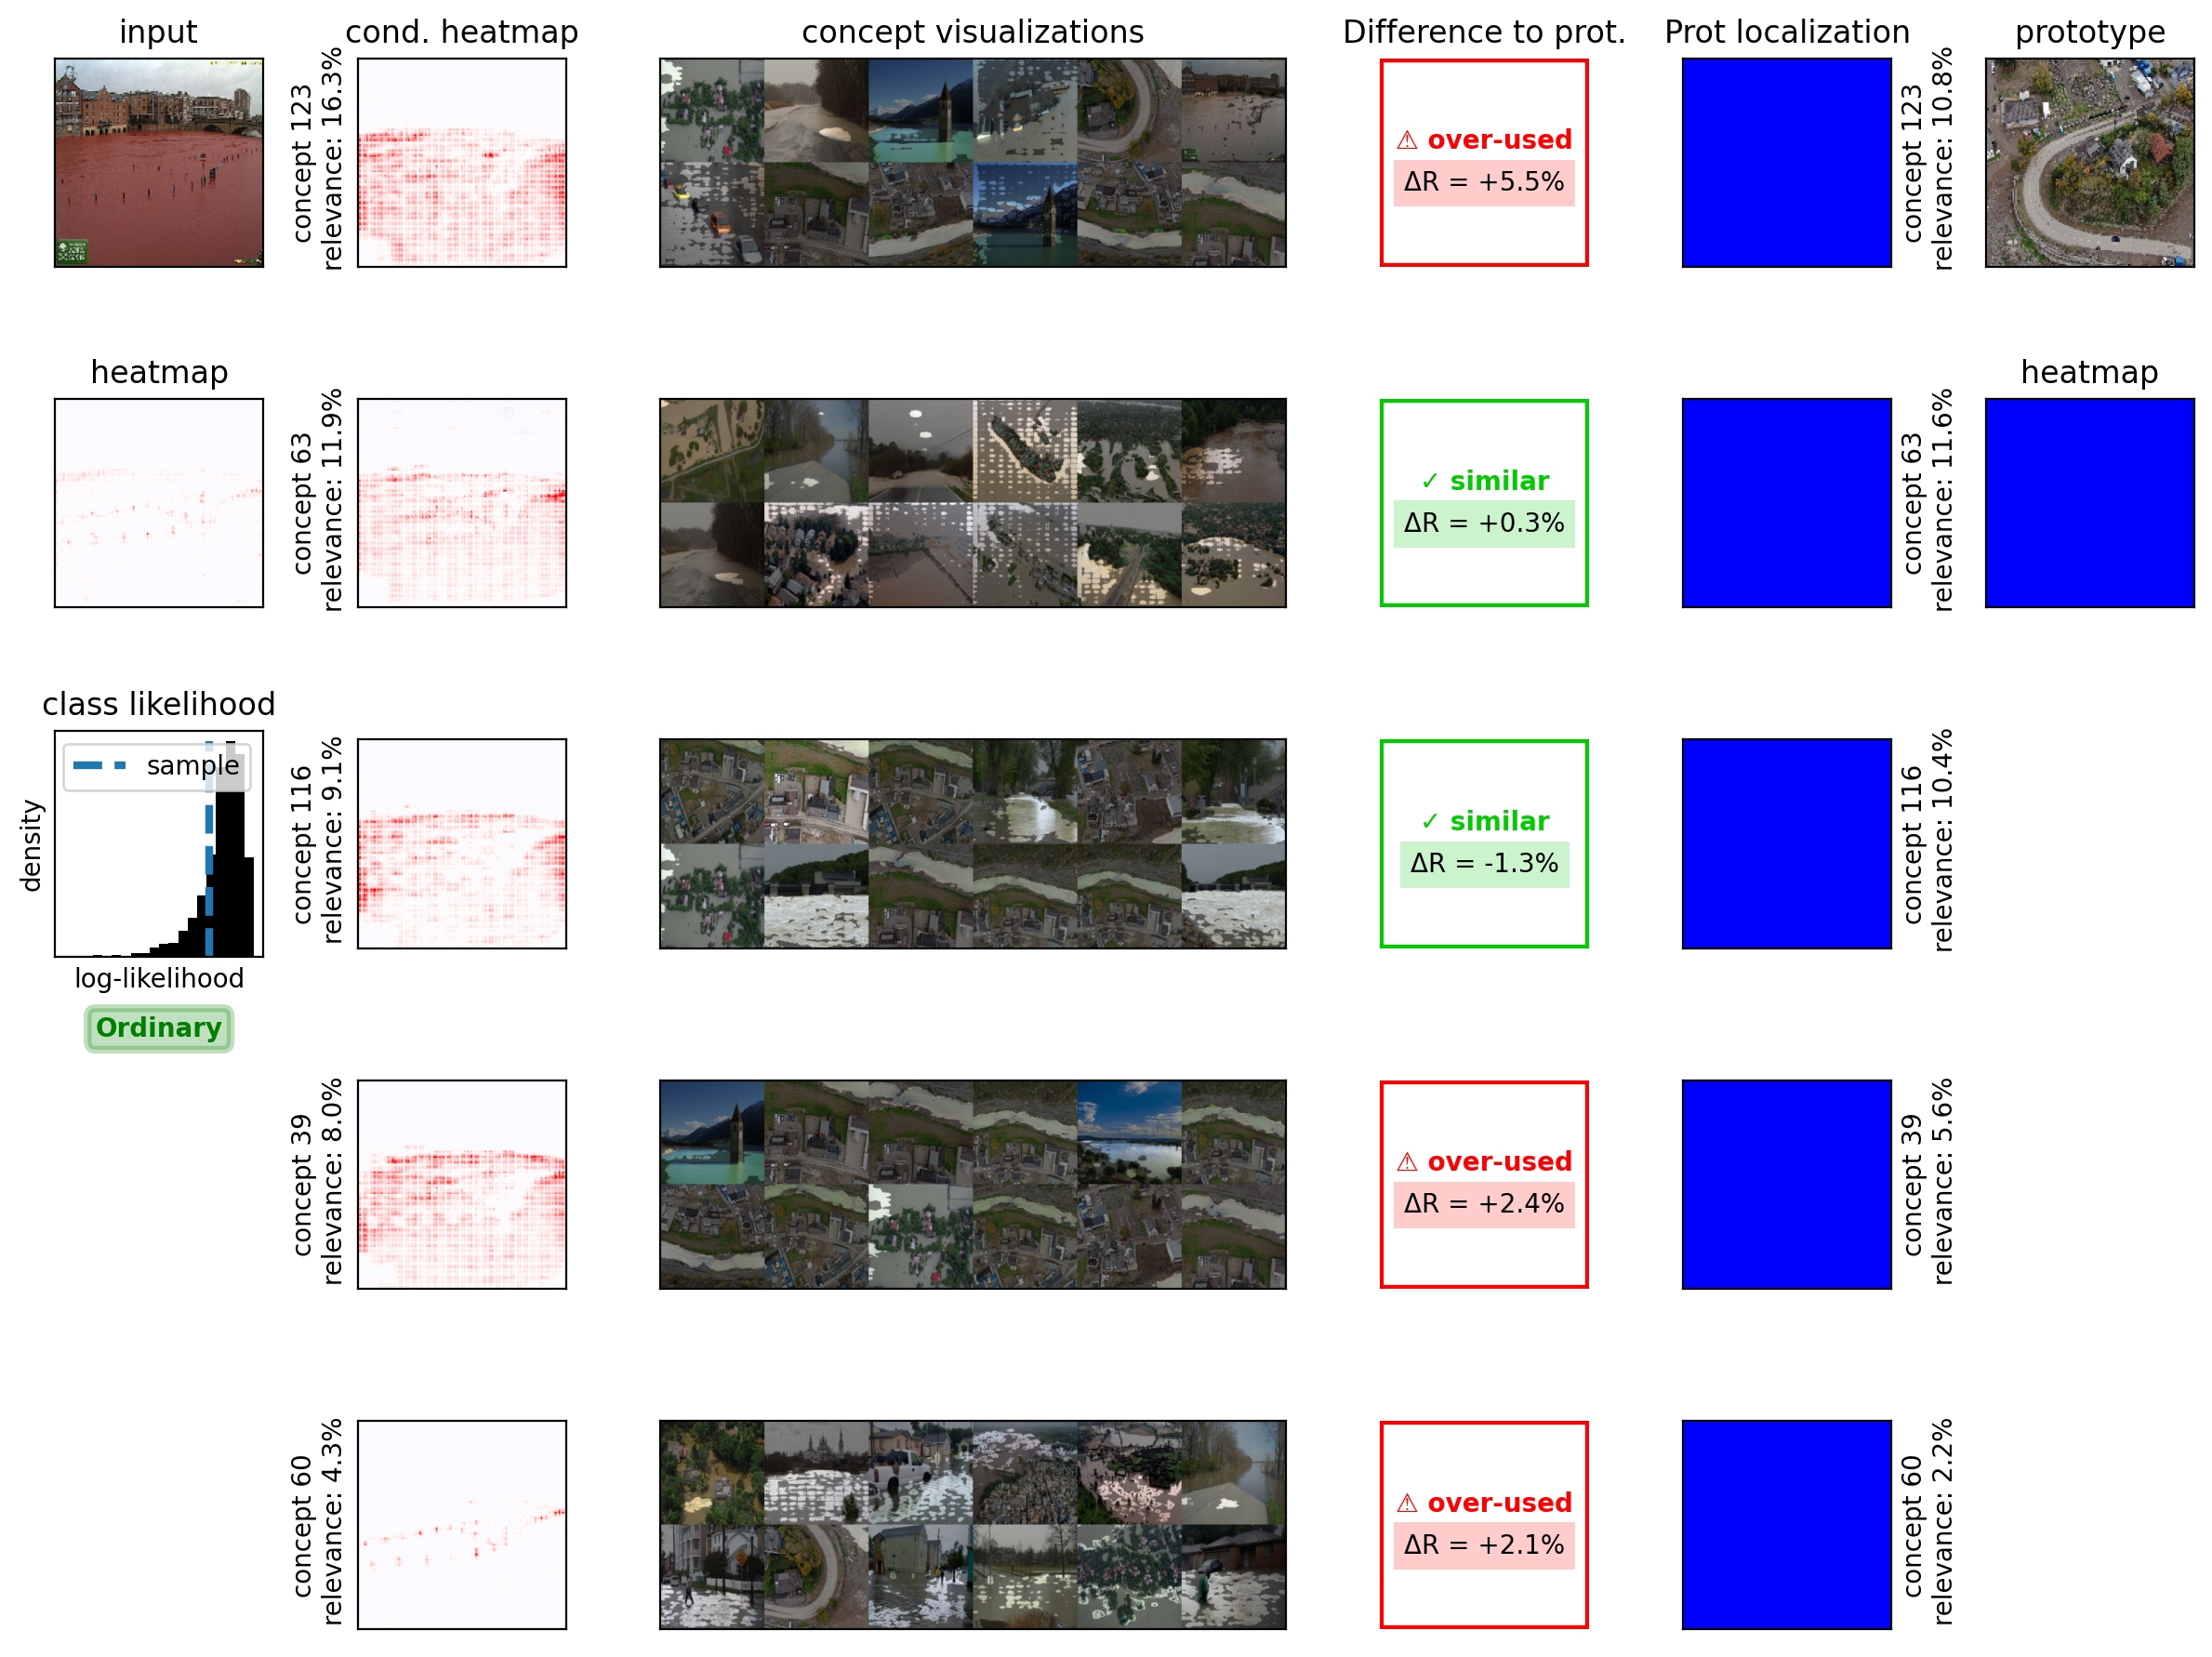

In [16]:
import os
from src.plot_pcx_pidnet_new import plot_pcx_explanations

root_dir = "../data/flood_segmentation/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)
print('Loaded dataset:', type(dataset))
print('len(dataset) =', len(dataset))

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Use parent-relative paths because this notebook lives in the `examples/` folder
output_dir_crp = "../examples/output/crp/pidnet_flood_BRK/"
output_dir_pcx = "../examples/output/pcx/pidnet_flood_BRK/"

plot_pcx_explanations(
    "pidnet",
    model.to(device),
    dataset,
    sample_id=0,
    layer_name='layer3.0.conv1',
    n_concepts=5,
    n_refimgs=12,
    num_prototypes=5,
    ref_imgs_path="../examples/ref_images_pidnet_flood_BRK",
    output_dir_crp=output_dir_crp,
    output_dir_pcx=output_dir_pcx,
)


In [17]:
from pathlib import Path
import datetime

p = Path("/home/heydari/FHHI-XAI/examples/output/pcx/pidnet_flood_BRK/layer3.1.conv2/activations.npy")
mtime = p.stat().st_mtime
print("mtime (timestamp):", mtime)
print("mtime (human):", datetime.datetime.fromtimestamp(mtime))

mtime (timestamp): 1763996045.4886723
mtime (human): 2025-11-24 15:54:05.488672


In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d])
# # Setting up CRP 
attribution = ATTRIBUTORS[model_name](model)
composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
condition = [{"y": 1}]  
fv = VISUALIZATIONS[model_name](attribution,
                                 dataset,
                                 layer_names,
                                 preprocess_fn=lambda x: x,
                                 path=output_dir,
                                 max_target="max")

# # Runs faster on MPS
#device = "mps"
model.to(device)
model.eval()

start = datetime.now()

activations = {}
attributions = {}
for i, (x, y) in enumerate(tqdm(dataset)):
     x = x.to(device).requires_grad_()
     condition = [{"y": 1}]
     attr = attribution(x.unsqueeze(0), condition, composite, record_layer=layer_names)

     for layer_name in layer_names:
         if layer_name in attr.activations.keys():
             if layer_name not in attributions.keys():
                 attributions[layer_name] = []
                 activations[layer_name] = []
             activations[layer_name].append(attr.activations[layer_name].amax((-2, -1)))
             attributions[layer_name].append(cc.attribute(attr.relevances[layer_name], abs_norm=True))

for layer_name in layer_names:
    if layer_name in attribution.keys():
        attributions[layer_name] = torch.cat(attributions[layer_name])
        activations[layer_name] = torch.cat(activations[layer_name])    
        folder = f"output/pcx/pidnet_flood_BRK/{layer_name}/"
        attributions[layer_name] = torch.cat(attributions[layer_name])
        activations[layer_name] = torch.cat(activations[layer_name])
        os.makedirs(folder, exist_ok=True)
        np.save(folder + "attributions", attributions[layer_name].cpu().numpy())
        np.save(folder + "activations", activations[layer_name].cpu().numpy())
end = datetime.now()

In [18]:
import numpy as np
a = np.load("/home/heydari/FHHI-XAI/examples/output/pcx/pidnet_flood_BRK/layer3.1.conv2/activations.npy")
print("shape", a.shape, "nan_count", np.isnan(a).sum(), "nan_rows", np.isnan(a).any(axis=1).sum())


shape (1321, 128) nan_count 0 nan_rows 0


In [ ]:
import numpy as np
p = "/Users/heydari/Desktop/test/FHHI-XAI-PIDNET/examples/output/pcx/pidnet_flood_BRK/layer3.0.conv1/attributions.npy"
a = np.load(p)
print("shape", a.shape, "nan_count", np.isnan(a).sum(), "nan_rows", np.isnan(a).any(axis=1).sum())

In [ ]:
import numpy as np
p = "/Users/heydari/Desktop/test/FHHI-XAI-PIDNET/examples/output/pcx/pidnet_flood/layer3_.0.conv1/attributions.npy"
a = np.load(p)
print("shape", a.shape, "nan_count", np.isnan(a).sum(), "nan_rows", np.isnan(a).any(axis=1).sum())

In [ ]:
# --- drop rows with NaN if any (fallback)
mask = ~np.isnan(attributions_np).any(axis=1)
removed = int((~mask).sum())
if removed > 0:
    print(f"[gmm] dropping {removed} samples with NaNs from attributions (fallback)")
    attributions_np = attributions_np[mask]
if attributions_np.shape[0] == 0:
    raise ValueError("All attribution samples are NaN; regenerate attributions before running PCX.")